In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
from imblearn.over_sampling import KMeansSMOTE
from sklearn.cluster import KMeans
import joblib
!pip install shap
import shap
from imblearn.over_sampling import KMeansSMOTE
from sklearn.cluster import KMeans
import joblib

In [4]:
RANDOM_STATE = 42
DATA_PATH = "train.csv"
TEST_DATA_PATH = "test.csv"

In [5]:
plt.rcParams['font.sans-serif'] = ['SimHei']
sns.set(style="whitegrid", palette="muted")

### [1/8] Data Loading

In [7]:
raw_df = pd.read_csv(DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)
print(f"Original Dataset Dimension：{raw_df.shape}")
raw_df

Original Dataset Dimension：(12243, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,Male,50.0,0,0,Yes,Private,Rural,88.10,29.1,formerly smoked,0
1,2,Female,52.0,0,0,Yes,Private,Rural,80.07,38.9,smokes,0
2,3,Female,26.0,0,0,No,Govt_job,Urban,89.11,23.3,smokes,0
3,4,Female,37.0,0,0,Yes,Private,Rural,81.36,36.1,never smoked,0
4,5,Male,59.0,0,0,Yes,Private,Rural,82.59,29.6,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
12238,12239,Female,32.0,0,0,Yes,Private,Urban,85.00,25.8,Unknown,0
12239,12240,Female,31.0,0,0,Yes,Govt_job,Urban,92.00,30.1,Unknown,0
12240,12241,Male,65.0,0,0,Yes,Private,Rural,91.44,30.9,Unknown,0
12241,12242,Female,75.0,0,0,Yes,Private,Urban,73.02,30.1,formerly smoked,0


### [2/8] Data Quality Check

In [9]:
# 1. Gender
gender_dist = raw_df['gender'].value_counts()
print("\nGender：")
print(gender_dist)


Gender：
gender
Female    7563
Male      4679
Other        1
Name: count, dtype: int64


In [10]:
# 2. Outliers
bmi_stats = raw_df['bmi'].describe(percentiles=[0.95, 0.99])
print("\nBMI：")
print(bmi_stats[['min', '50%', 'max', '99%']])


BMI：
min    10.3
50%    27.6
max    80.1
99%    46.9
Name: bmi, dtype: float64


### [3/8] Data Cleaning

In [12]:
# Filter out ineffective gender
df_clean = raw_df[raw_df['gender'].isin(['Male', 'Female'])].copy()
test_df_clean = test_df.copy()

In [13]:
# Outliers
bmi_q99 = df_clean['bmi'].quantile(0.99)
print(f"\nBMI Upper Limits={bmi_q99:.1f}")
df_clean['bmi'] = df_clean['bmi'].clip(upper=bmi_q99)


print("\nBMI：")
print(df_clean['bmi'].describe()[['min', '50%', 'max']])

test_df_clean['bmi'] = test_df_clean['bmi'].clip(upper=bmi_q99)


BMI Upper Limits=46.9

BMI：
min    10.3
50%    27.6
max    46.9
Name: bmi, dtype: float64


### [4/8] Feature Engineering

In [15]:
df_clean['gender'] = df_clean['gender'].map({'Male':1, 'Female':0})
df_clean['ever_married'] = df_clean['ever_married'].map({'Yes':1, 'No':0})
df_clean['Residence_type'] = df_clean['Residence_type'].map({'Rural':0, 'Urban':1})

test_df_clean['gender'] = test_df_clean['gender'].map({'Male':1, 'Female':0})
test_df_clean['ever_married'] = test_df_clean['ever_married'].map({'Yes':1, 'No':0})
test_df_clean['Residence_type'] = test_df_clean['Residence_type'].map({'Rural':0, 'Urban':1})

In [16]:
age_bins = [0, 18, 45, 65, 100]
age_labels = [0, 1, 2, 3]
df_clean['age_bin'] = pd.cut(df_clean['age'], bins=age_bins, labels=age_labels)

test_df_clean['age_bin'] = pd.cut(test_df_clean['age'], bins=age_bins, labels=age_labels)

In [17]:
# glucose categorization
# https://www.mayoclinic.org/tests-procedures/glucose-tolerance-test/about/pac-20394296
glucose_bins = [0, 140, 200, 300]
glucose_labels = [0, 1, 2]
df_clean['glucose_bin'] = pd.cut(df_clean['avg_glucose_level'], bins=glucose_bins, labels=glucose_labels)

test_df_clean['glucose_bin'] = pd.cut(test_df_clean['avg_glucose_level'], bins=glucose_bins, labels=glucose_labels)

In [18]:
# BMI Categorization
# https://www.ncbi.nlm.nih.gov/books/NBK541070/
bmi_bins = [0, 18.5, 25, 30, 50]
bmi_labels = [0, 1, 2, 3]
df_clean['bmi_bin'] = pd.cut(df_clean['bmi'], bins=bmi_bins, labels=bmi_labels)

test_df_clean['bmi_bin'] = pd.cut(test_df_clean['bmi'], bins=bmi_bins, labels=bmi_labels)

In [19]:
# High-Risk Population Identification (Meeting Any Two Risk Factors)

df_clean['high_risk'] = (
    (df_clean['hypertension'] == 1).astype(int) +
    (df_clean['heart_disease'] == 1).astype(int) +
    (df_clean['glucose_bin'] == 2).astype(int)
) >= 2

test_df_clean['high_risk'] = (
    (test_df_clean['hypertension'] == 1).astype(int) +
    (test_df_clean['heart_disease'] == 1).astype(int) +
    (test_df_clean['glucose_bin'] == 2).astype(int)
) >= 2

In [20]:
# New feature added
df_clean['cv_risk'] = df_clean['hypertension'] + df_clean['heart_disease']
df_clean['age_glucose'] = df_clean['age'] * df_clean['avg_glucose_level'] / 100

test_df_clean['cv_risk'] = test_df_clean['hypertension'] + test_df_clean['heart_disease']
test_df_clean['age_glucose'] = test_df_clean['age'] * test_df_clean['avg_glucose_level'] / 100

In [21]:
# Work type risk
work_type_map = {
    'children':0,
    'Never_worked':1,
    'Private':2,
    'Govt_job':3,
    'Self-employed':4
}
df_clean['work_type'] = df_clean['work_type'].map(work_type_map)

test_df_clean['work_type'] = test_df_clean['work_type'].map(work_type_map)

In [22]:
# Smoking classification
df_clean['smoking_status'] = np.select(
    [
        df_clean['smoking_status'] == 'smokes',
        df_clean['smoking_status'] == 'formerly smoked',
        df_clean['smoking_status'] == 'never smoked',
        df_clean['smoking_status'] == 'Unknown'
    ],
    [3, 2, 1, 0],
    default=0
)

test_df_clean['smoking_status'] = np.select(
    [
        test_df_clean['smoking_status'] == 'smokes',
        test_df_clean['smoking_status'] == 'formerly smoked',
        test_df_clean['smoking_status'] == 'never smoked',
        test_df_clean['smoking_status'] == 'Unknown'
    ],
    [3, 2, 1, 0],
    default=0
)

In [23]:
features = [
    # Original features
    'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
    'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status',
    # Binning features
    'age_bin', 'glucose_bin', 'bmi_bin',
    # Engineering features
    'high_risk', 'cv_risk', 'age_glucose'
]
df_final  = df_clean[features + ['stroke']]

test_df_final = test_df_clean[features]

### [5/8] Data Split

In [25]:
X = df_final.drop('stroke', axis=1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

### [6/8] Data Preprocessing

In [27]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

test_df_scaled = scaler.transform(test_df_final)

In [28]:
# Oversampling
print("Before：", dict(pd.Series(y_train).value_counts()))
smote = KMeansSMOTE(
    sampling_strategy=0.5,
    kmeans_estimator=KMeans(n_clusters=5, random_state=RANDOM_STATE),
    cluster_balance_threshold=0.1,
    random_state=RANDOM_STATE
)

X_res, y_res = smote.fit_resample(X_train_scaled, y_train)
print("After：", dict(pd.Series(y_res).value_counts()))

df_train_resampled = pd.concat([pd.DataFrame(X_res, columns=X.columns),
                                pd.DataFrame(y_res, columns=['stroke'])], axis=1)

# Display first few rows of the resampled training set
df_train_resampled.head()

Before： {0: 9388, 1: 405}
After： {0: 9388, 1: 4695}


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,age_bin,glucose_bin,bmi_bin,high_risk,cv_risk,age_glucose,stroke
0,-0.790478,-1.828443,-0.228267,-0.156117,-1.437046,-1.932435,0.992371,0.012862,-1.775210,-1.134267,-1.501009,-0.167425,-2.059740,-0.098447,-0.269768,-1.424621,0
1,-0.790478,-0.337989,-0.228267,-0.156117,0.695872,0.867851,-1.007688,-0.396692,0.870896,-0.131570,-0.427278,-0.167425,1.142181,-0.098447,-0.269768,-0.415393,0
2,-0.790478,-0.059574,-0.228267,-0.156117,0.695872,-0.065577,-1.007688,-0.941152,0.702647,-0.131570,-0.427278,-0.167425,1.142181,-0.098447,-0.269768,-0.442328,0
3,1.265058,0.358050,-0.228267,-0.156117,0.695872,0.867851,-1.007688,-0.353199,0.304966,0.871127,0.646454,-0.167425,0.074874,-0.098447,-0.269768,0.080720,0
4,1.265058,0.358050,-0.228267,-0.156117,0.695872,-0.065577,-1.007688,-0.759129,-0.383327,-1.134267,0.646454,-0.167425,0.074874,-0.098447,-0.269768,-0.117369,0


In [29]:
X_train_resampled = df_train_resampled.drop(columns=['stroke']).copy()
y_train_resampled = df_train_resampled['stroke'].copy()

In [30]:
print(df_train_resampled.duplicated().sum())

0


In [31]:
# Drop duplicates
df_train_resampled.drop_duplicates(inplace=True)

### [7/8] Model Training

# Classifier 1： Light GBM

In [34]:
params = {
    'objective':'binary',
    'metric':'f1',
    'num_leaves':45,
    'learning_rate':0.08,
    'feature_fraction':0.7,
    'min_child_samples':30,
    'reg_alpha':0.3,
    'reg_lambda':0.2,
    'scale_pos_weight':10,
    'verbosity':-1,
    'random_state':RANDOM_STATE
}
model = lgb.LGBMClassifier(**params)
model.fit(X_res, y_res)

LGBMClassifier(feature_fraction=0.7, learning_rate=0.08, metric='f1',
               min_child_samples=30, num_leaves=45, objective='binary',
               random_state=42, reg_alpha=0.3, reg_lambda=0.2,
               scale_pos_weight=10, verbosity=-1)

In [35]:
y_pred = model.predict(X_test_scaled)
print("\nReport：")
print(classification_report(y_test, y_pred, target_names=['Non-stroke', 'Stroke']))


Report：
              precision    recall  f1-score   support

  Non-stroke       0.98      0.92      0.95      2348
      Stroke       0.21      0.48      0.29       101

    accuracy                           0.91      2449
   macro avg       0.59      0.70      0.62      2449
weighted avg       0.94      0.91      0.92      2449



In [36]:
!pip install optuna

import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
    'objective': 'binary',
    'metric': 'f1',
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
    'num_leaves': trial.suggest_int('num_leaves', 20, 200, step=10),
    'max_depth': trial.suggest_int('max_depth', 3, 15),
    'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
    'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1e1),
    'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 1e1),
    'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 50),
    'random_state': RANDOM_STATE,
    'verbosity': -1
}


    model = LGBMClassifier(**params)
    score = cross_val_score(model, X_res, y_res, cv=5, scoring='f1').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)  # Run 30 trials

print("Best Parameters:", study.best_params)
print("Best F1 Score:", study.best_value)

[I 2025-03-13 10:24:04,505] A new study created in memory with name: no-name-8407f752-bd27-4076-9d17-8627e3e6c400
/var/folders/dn/8ml2m0mx3dzcqjk1jrh3h5ph0000gn/T/ipykernel_98742/2451761897.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/var/folders/dn/8ml2m0mx3dzcqjk1jrh3h5ph0000gn/T/ipykernel_98742/2451761897.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/var/folders/dn/8ml2m0mx3dzcqjk1jrh3h5ph0000gn/T/ipykernel_98742/2451761897.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.

Best Parameters: {'learning_rate': 0.17975000763968157, 'num_leaves': 90, 'max_depth': 13, 'min_child_samples': 43, 'feature_fraction': 0.5431225630892412, 'subsample': 0.721369144255585, 'colsample_bytree': 0.5059716799940046, 'reg_alpha': 1.0168323247229487, 'reg_lambda': 0.3462330151839712, 'scale_pos_weight': 13}
Best F1 Score: 0.8980929342901905


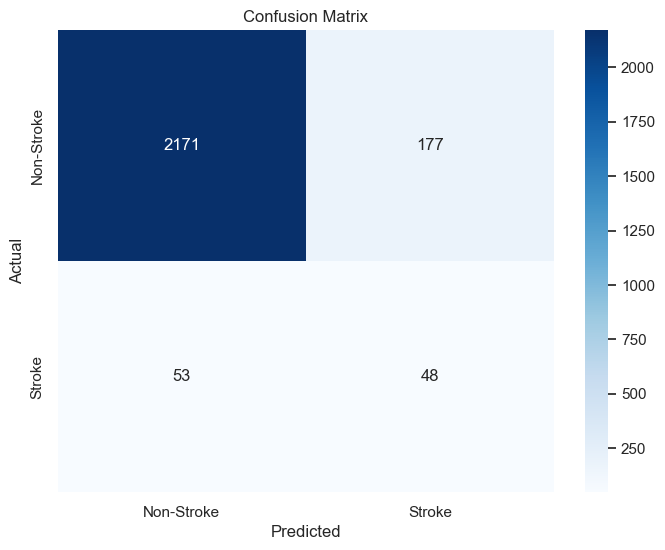

In [37]:
# Confusion Matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Non-Stroke', 'Stroke'],
           yticklabels=['Non-Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [38]:
importances = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train_resampled.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance_df)


Feature Importance:
              Feature  Importance
8                 bmi         849
7   avg_glucose_level         781
15        age_glucose         681
1                 age         680
9      smoking_status         452
5           work_type         218
10            age_bin         158
6      Residence_type         140
12            bmi_bin         119
0              gender         117
14            cv_risk          79
2        hypertension          48
4        ever_married          36
3       heart_disease          28
11        glucose_bin           8
13          high_risk           6


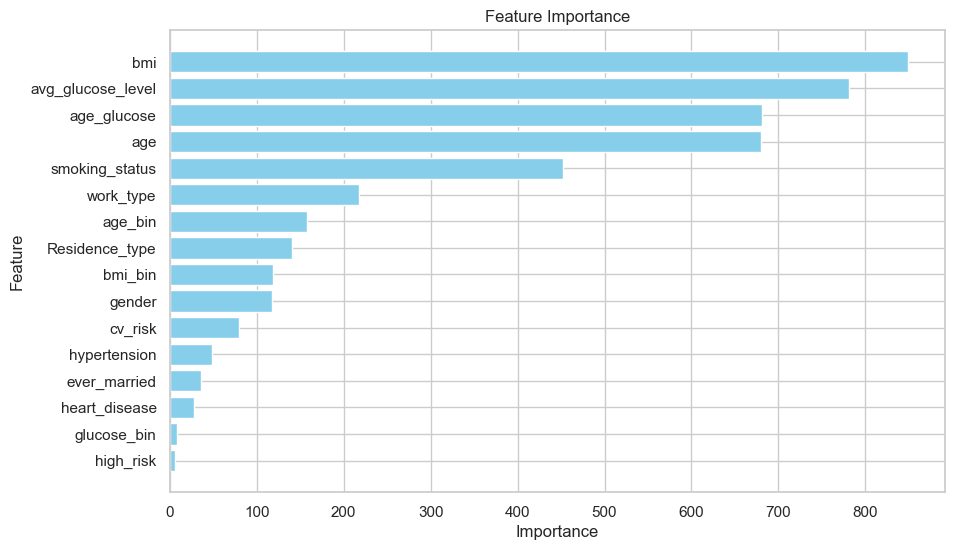

In [39]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

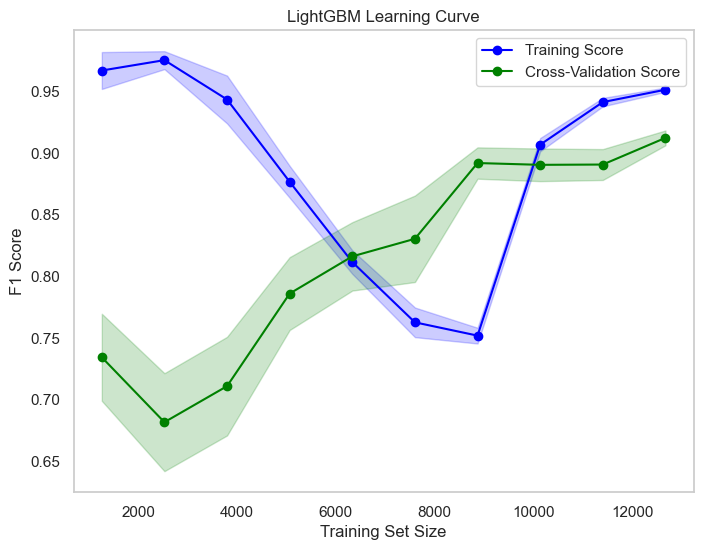

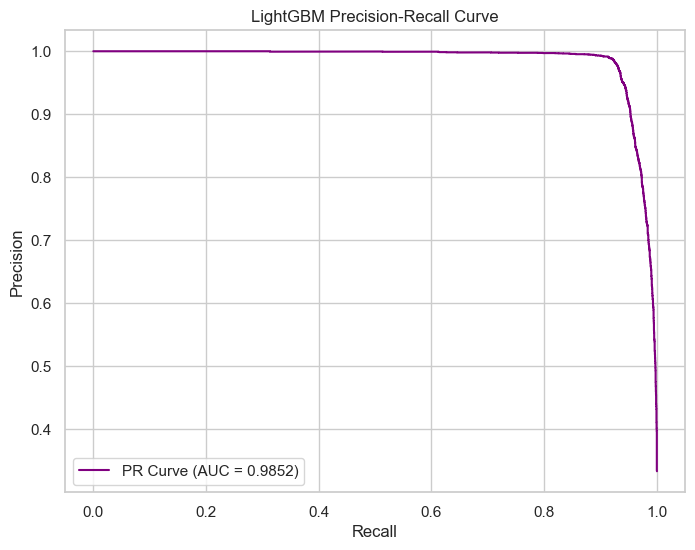

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, auc

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_res, y_res,
    cv=cv, scoring='f1', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Learning curve plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', marker='o', color='green')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('LightGBM Learning Curve')
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curve
y_prob_lgbm = cross_val_predict(model, X_res, y_res, cv=cv, method='predict_proba')[:, 1]
precision, recall, _ = precision_recall_curve(y_res, y_prob_lgbm)
pr_auc = auc(recall, precision)

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('LightGBM Precision-Recall Curve')
plt.legend()

# Classifier 2: XGBoost

In [42]:
from xgboost import XGBClassifier
# Compute class imbalance ratio
class_0, class_1 = np.bincount(y_train_resampled)
balanced_weight = class_0 / class_1  # Ratio of majority/minority class

# Initialize and train XGBoost with correct weight
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    scale_pos_weight=balanced_weight,  # Fix here
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_train_resampled)
print(f"F1 Score with XGBoost: {f1_score(y_train_resampled, y_pred_xgb)}")

F1 Score with XGBoost: 0.947043811144194


# Other Classifier

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=6, class_weight='balanced', random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)
y_pred_dt = dt_model.predict(X_train_resampled)
print(f"F1 Score with Decision Tree: {f1_score(y_train_resampled, y_pred_dt):.4f}")

# k-Nearest Neighbors (k-NN)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_resampled, y_train_resampled)
y_pred_knn = knn_model.predict(X_train_resampled)
print(f"F1 Score with k-NN: {f1_score(y_train_resampled, y_pred_knn):.4f}")

# Support Vector Machine (SVM)
svm_model = SVC(kernel='rbf', C=1.0, probability=True, class_weight='balanced', random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm_model.predict(X_train_resampled)
print(f"F1 Score with SVM: {f1_score(y_train_resampled, y_pred_svm):.4f}")

F1 Score with Decision Tree: 0.9352
F1 Score with k-NN: 0.9499
F1 Score with SVM: 0.9123


In [45]:
# choose Light GBM
y_test_pred = model.predict(test_df_scaled)
# Submit File
submission_df = pd.DataFrame({
    'id': range(1, len(y_test_pred) + 1),
    'stroke': y_test_pred
})
submission_df

,id,stroke
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
3056,3057,0
3057,3058,0
3058,3059,0
3059,3060,0


# Explanation Generation

## Local Explanation - Anchor

In [47]:
!pip install alibi

import numpy as np
from sklearn.model_selection import train_test_split
from alibi.explainers import AnchorTabular

X_res_df = pd.DataFrame(X_res, columns=X.columns)
X_res_np = X_res_df.to_numpy()

# Ensure feature names are a list
feature_names = list(X_res_df.columns)

# Initialize the explainer
explainer = AnchorTabular(predictor=model.predict, feature_names=feature_names)

# Fit the explainer with correctly formatted input
explainer.fit(X_res_np, disc_perc=[25, 50, 75])

for i in range(3):
    instance = X_test_scaled[i]  # Now this correctly selects the ith row
    explanation = explainer.explain(instance, threshold=0.95)

    print(f"Instance {i+1} Prediction:", 
          "Malignant" if model.predict(instance.reshape(1, -1))[0] == 0 else "Benign")
    print("Anchor: %s" % (' AND '.join(explanation.anchor)))
    print("Precision: %.2f" % explanation.precision)
    print("Coverage: %.2f" % explanation.coverage)
    print("\n")

Instance 1 Prediction: Malignant
Anchor: age <= 0.61 AND age_glucose <= 2.98 AND cv_risk <= -0.27
Precision: 1.00
Coverage: 0.47


Instance 2 Prediction: Malignant
Anchor: age <= 0.61 AND age_bin <= -0.43
Precision: 1.00
Coverage: 0.38


Instance 3 Prediction: Malignant
Anchor: age <= 0.61 AND age_bin <= -0.43
Precision: 1.00
Coverage: 0.37




# Global Explanation
## Feature importance/impact assessment: Permutation Feature Importance

Current features in X_train_resampled: Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'age_bin', 'glucose_bin', 'bmi_bin', 'high_risk',
       'cv_risk', 'age_glucose'],
      dtype='object')


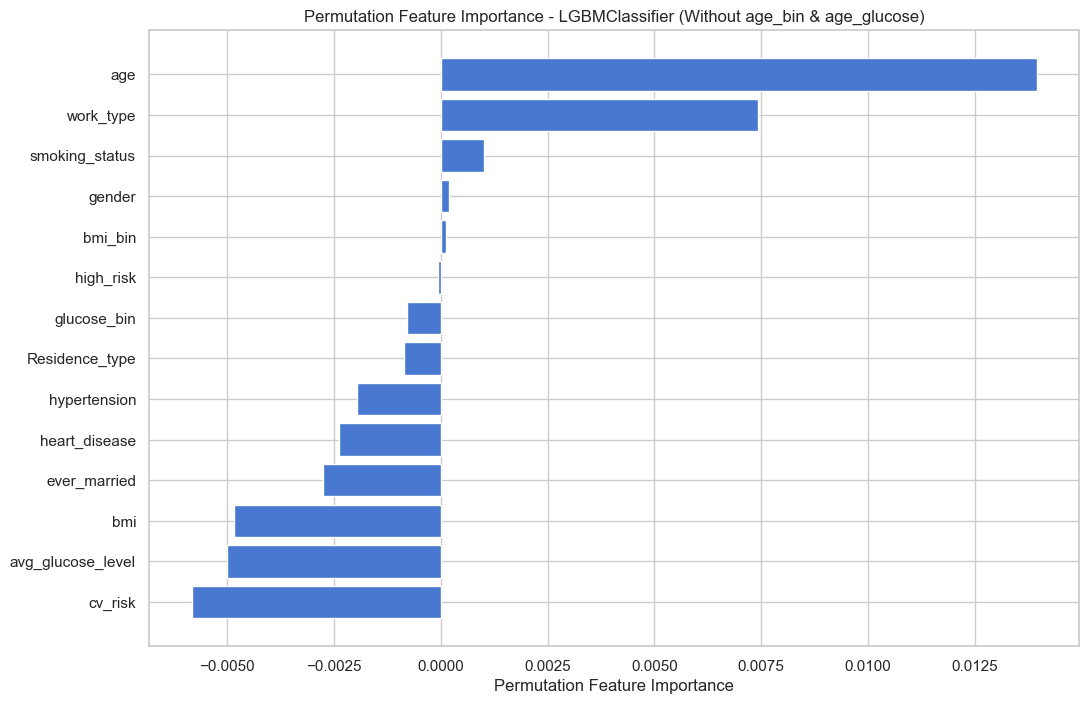

Permutation Feature Importance - LGBMClassifier (Without age_bin & age_glucose)


In [72]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train_resampled.columns)
if isinstance(X_res, np.ndarray):
    X_res = pd.DataFrame(X_res, columns=X_train_resampled.columns)

# remove 'age_bin' & 'age_glucose' 
print("Current features in X_train_resampled:", X_train_resampled.columns)
columns_to_drop = ['age_bin', 'age_glucose']
existing_columns_to_drop = [col for col in columns_to_drop if col in X_train_resampled.columns]
X_train_filtered = X_train_resampled.drop(columns=existing_columns_to_drop)
X_test_filtered = X_test_scaled_df.drop(columns=existing_columns_to_drop)

# Make predictions
model = lgb.LGBMClassifier(**params)
model.fit(X_res.drop(columns=existing_columns_to_drop), y_res)  

# compute the Permutation Feature Importance
perm_importance = permutation_importance(model, X_test_filtered, y_test, n_repeats=30, random_state=42)

# Get sorted feature importance
sorted_idx = perm_importance.importances_mean.argsort()

# Correctly index data.feature_names to match sorted indices
feature_names_filtered = X_train_filtered.columns
feature_names_sorted = [feature_names_filtered[i] for i in sorted_idx]

# plot
plt.figure(figsize=(12, 8))
plt.barh(range(X_test_filtered.shape[1]), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(X_test_filtered.shape[1]), feature_names_sorted)
plt.xlabel("Permutation Feature Importance")
plt.title("Permutation Feature Importance - LGBMClassifier (Without age_bin & age_glucose)")
plt.show()

print("Permutation Feature Importance - LGBMClassifier (Without age_bin & age_glucose)")

# Fairness

Gender Demographic Parity Difference: 0.0103
Age Demographic Parity Difference: 0.9524


/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


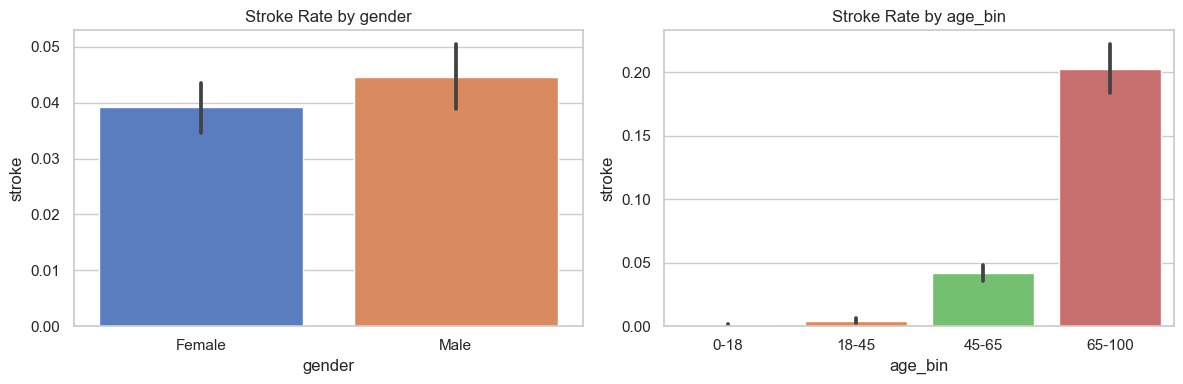

In [49]:
from fairlearn.metrics import demographic_parity_difference

# Calculate gender dimension fairness differences
demo_parity_diff = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['gender']
)
print(f"Gender Demographic Parity Difference: {demo_parity_diff:.4f}")

# Calculate age dimension fairness differences
demo_parity_diff = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['age']
)
print(f"Age Demographic Parity Difference: {demo_parity_diff:.4f}")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(x=df_final['gender'], y=df_final['stroke'])
plt.xticks([0, 1], ['Female', 'Male'])
plt.title(f'Stroke Rate by gender')
plt.subplot(1,2,2)
sns.barplot(x=df_final['age_bin'], y=df_final['stroke'])
plt.xticks([0, 1, 2, 3], ['0-18', '18-45', '45-65', '65-100'])
plt.title(f'Stroke Rate by age_bin')
plt.tight_layout()

In [66]:
# Fairness 

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assume the sensitive feature is one of the columns
sensitive_feature_name = 'age'

# Ensure the sensitive feature is included
# Convert the NumPy array to a DataFrame
X_res_df = pd.DataFrame(X_res, columns=X.columns)
sensitive_feature_name = 'age'
sensitive_feature = X_res_df[[sensitive_feature_name]]

# Split the dataset into training and test sets
x2_train, x2_test, y2_train, y2_test, sensitive_feature_train, sensitive_feature_test = train_test_split(X_res_df, y_res, sensitive_feature, test_size=0.2, random_state=999)

# Reset indices for all DataFrames
x2_train = x2_train.reset_index(drop=True)
y2_train = y2_train.reset_index(drop=True)
sensitive_feature_train = sensitive_feature_train.reset_index(drop=True)

# Make predictions
y2_pred = model.predict(x2_test)

# Assess fairness using MetricFrame
print('Original Metrics BEFORE Bias Mitigation\n')
mf = MetricFrame(metrics={'accuracy': accuracy_score, 'selection_rate': selection_rate},
                 y_true=y2_test,
                 y_pred=y2_pred,
                 sensitive_features=sensitive_feature_test[sensitive_feature_name])

print(mf.by_group)

# Identify and filter out degenerate sensitive feature values
degenerate_values = []
for value in sensitive_feature_train[sensitive_feature_name].unique():
    y_subset = y2_train[sensitive_feature_train[sensitive_feature_name] == value]
    if y_subset.nunique() <= 1:  # Only one unique label (degenerate)
        degenerate_values.append(value)

valid_indices = ~sensitive_feature_train[sensitive_feature_name].isin(degenerate_values)
x2_train_filtered = x2_train[valid_indices]
y2_train_filtered = y2_train[valid_indices]
sensitive_feature_train_filtered = sensitive_feature_train[valid_indices]

# Mitigate bias using ThresholdOptimizer
postprocessor = ThresholdOptimizer(estimator=model, constraints="equalized_odds", prefit=True)
postprocessor.fit(x2_train_filtered, y2_train_filtered, sensitive_features=sensitive_feature_train_filtered[sensitive_feature_name])

# Adjusted predictions
y_pred_adj = postprocessor.predict(x2_test, sensitive_features=sensitive_feature_test[sensitive_feature_name])

# Re-evaluate fairness
print('Metrics AFTER Bias Mitigation\n')
mf_adj = MetricFrame(metrics={'accuracy': accuracy_score, 'selection_rate': selection_rate},
                     y_true=y2_test,
                     y_pred=y_pred_adj,
                     sensitive_features=sensitive_feature_test[sensitive_feature_name])

print(mf_adj.by_group)

Original Metrics BEFORE Bias Mitigation

           accuracy  selection_rate
age                                
-1.911968  1.000000             0.0
-1.908255  1.000000             0.0
-1.904543  1.000000             0.0
-1.900831  1.000000             0.0
-1.897119  1.000000             0.0
...             ...             ...
 1.882014  1.000000             1.0
 1.886264  1.000000             1.0
 1.887847  1.000000             1.0
 1.887856  1.000000             1.0
 1.889338  0.870968             1.0

[877 rows x 2 columns]
Metrics AFTER Bias Mitigation

           accuracy  selection_rate
age                                
-1.911968  1.000000        0.000000
-1.908255  1.000000        0.000000
-1.904543  1.000000        0.000000
-1.900831  1.000000        0.000000
-1.897119  1.000000        0.000000
...             ...             ...
 1.882014  0.000000        0.000000
 1.886264  0.000000        0.000000
 1.887847  0.000000        0.000000
 1.887856  0.000000        0.000000
 1.8